In [1]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

from src.project_config import get_paths, get_paths_protein, get_aa_list
from src.bias. compute_variant_bias import compute_variant_bias
import pandas as pd
import os
from tqdm.notebook import tqdm
import numpy as np
from os import mkdir
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


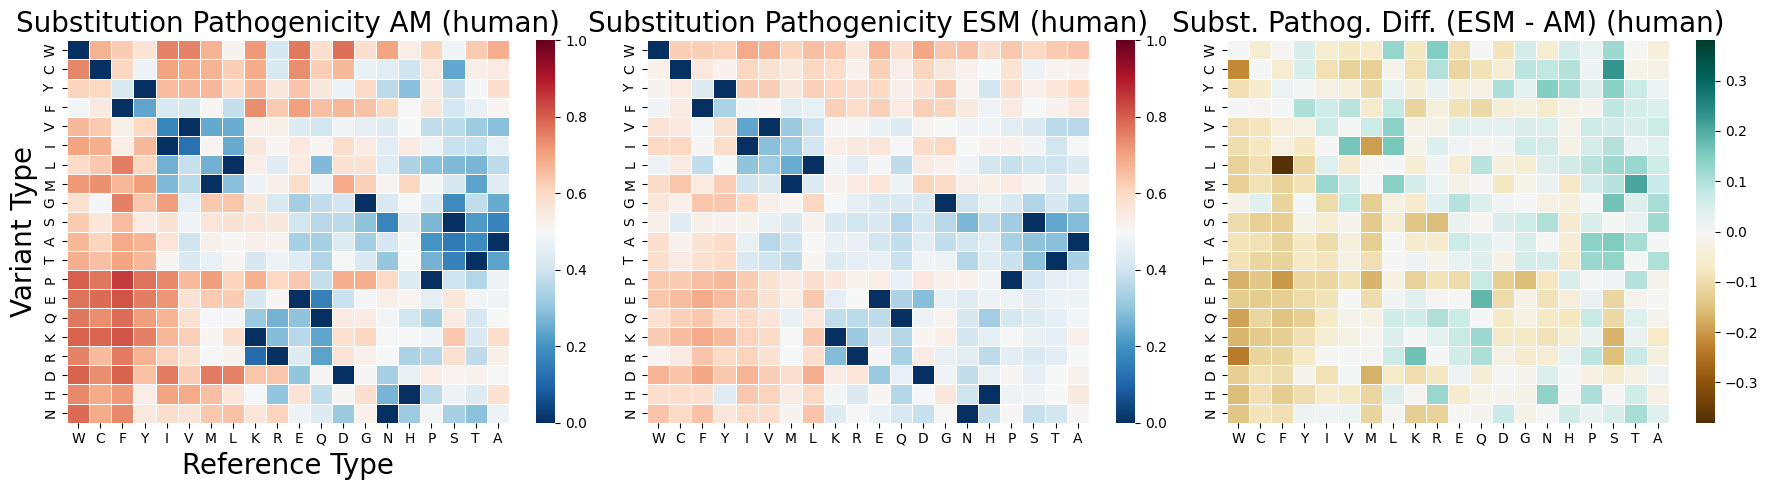

In [159]:
# Load the matrices
PROTEOME = "human"
matrix_am = pd.read_csv(get_paths()["processed"] / "5.6.Bias" / f"am_20x20_matrix{"" if PROTEOME == "human" else "_"}{"" if PROTEOME == "human" else PROTEOME}.csv", index_col=0)
matrix_esm = pd.read_csv(get_paths()["processed"] / "5.6.Bias" / f"esm_20x20_matrix{"" if PROTEOME == "human" else "_"}{"" if PROTEOME == "human" else PROTEOME}.csv", index_col=0)
difference_matrix = pd.read_csv(get_paths()["processed"] / "5.6.Bias" / f"difference_matrix{"" if PROTEOME == "human" else "_"}{"" if PROTEOME == "human" else PROTEOME}.csv", index_col=0)
# Reorder the indices (example order)

new_order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
new_order_reversed = new_order[::-1]
matrix_am = matrix_am.reindex(index=new_order_reversed, columns=new_order_reversed)
matrix_esm = matrix_esm.reindex(index=new_order_reversed, columns=new_order_reversed)

matrix_am = matrix_am.loc[ordered_row, ordered_column]
matrix_esm = matrix_esm.loc[ordered_row, ordered_column]
difference_matrix = difference_matrix.loc[ordered_row, ordered_column]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap for matrix_am
sns.heatmap(matrix_am, linewidth=0.5, cmap="RdBu_r", vmax=1, vmin=0.0, ax=axes[0])
axes[0].set_title(f'Substitution Pathogenicity AM ({PROTEOME})', fontsize=20)
axes[0].set_ylabel('Variant Type', fontsize=20)
axes[0].set_xlabel('Reference Type')

# Heatmap for matrix_esm
sns.heatmap(matrix_esm, linewidth=0.5, cmap="RdBu_r", vmax=1, vmin=0, ax=axes[1])
axes[1].set_title(f'Substitution Pathogenicity ESM ({PROTEOME})', fontsize=20)
axes[0].set_xlabel('Reference Type')

# Heatmap for difference_matrix
sns.heatmap(difference_matrix, linewidth=0.5, cmap="BrBG", vmax=0.38, vmin=-0.38, ax=axes[2])
axes[2].set_title(f'Subst. Pathog. Diff. (ESM - AM) ({PROTEOME})', fontsize=20)
axes[0].set_xlabel('Reference Type', fontsize=20)

plt.tight_layout()
plt.savefig(get_paths()["images_path"] / "1.4.Substitution_matrix" / f"substitution_heatmaps_{PROTEOME}_proteome_dendrogrammed_am.png")
plt.show()

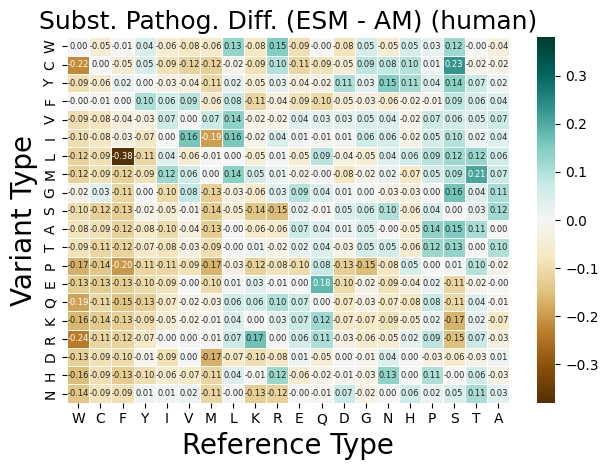

In [168]:
# Heatmap for difference_matrix
diff = sns.heatmap(difference_matrix, linewidth=0.5, cmap="BrBG", vmax=0.38, vmin=-0.38, annot=True, fmt=".2f", annot_kws={"size": 6})
diff.set_ylabel('Variant Type', fontsize=20)
diff.set_title(f'Subst. Pathog. Diff. (ESM - AM) ({PROTEOME})', fontsize=18)
diff.set_xlabel('Reference Type', fontsize=20)
plt.tight_layout()
#plt.savefig(get_paths()["images_path"] / "1.4.Substitution_matrix" / f"substitution_heatmaps_{PROTEOME}_proteome_dendrogrammed_difference_alone.png", dpi=300)
plt.show()

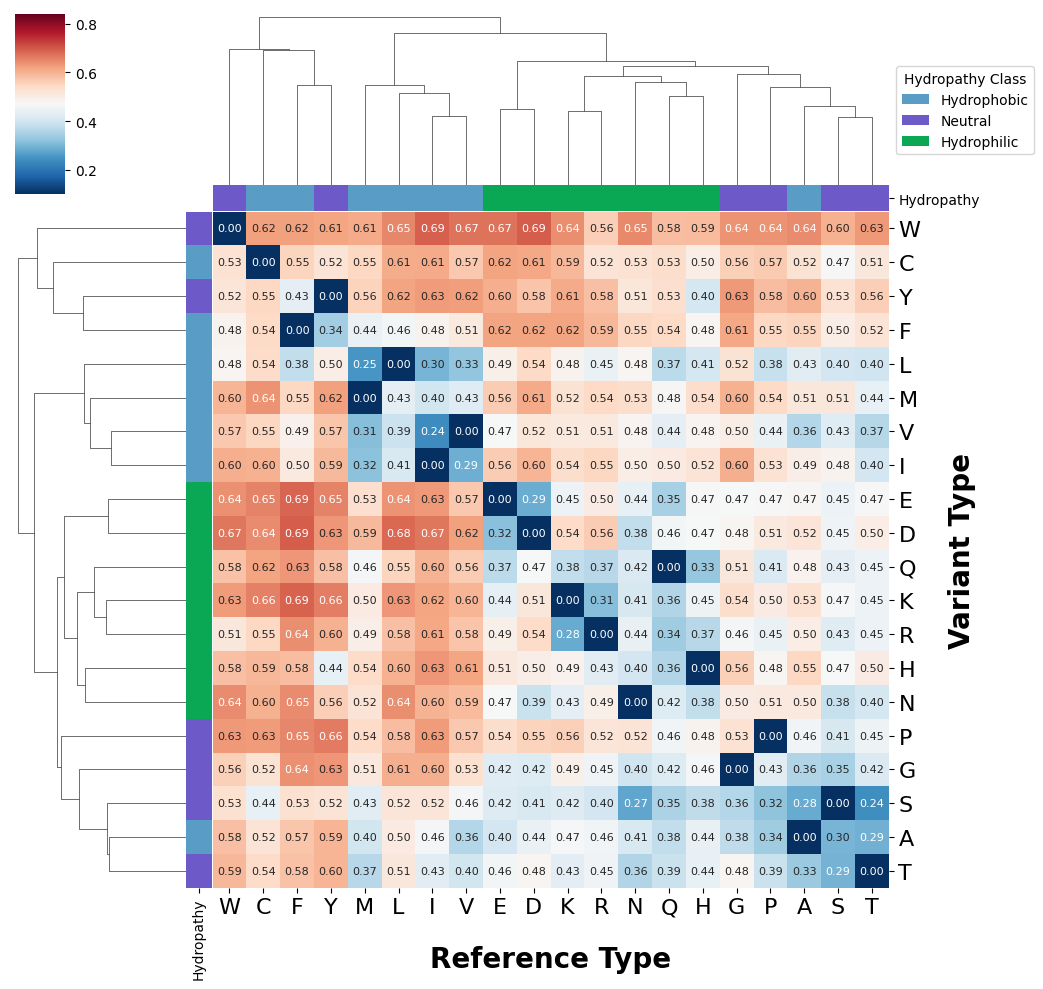

Index(['W', 'C', 'Y', 'F', 'P', 'E', 'K', 'R', 'Q', 'D', 'N', 'H', 'G', 'S',
       'T', 'A', 'V', 'I', 'M', 'L'],
      dtype='object')


In [164]:

dataset = matrix_esm.copy()

# Suppose your index/columns are amino acid codes
aa_labels = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']


aa_groups = {
    'HYDROPHOBIC': ['I', 'V', 'L', 'F', 'C', 'M', 'A'],
    'NEUTRAL': ['W', 'G', 'T', 'S', 'Y', 'P'],
    'HYDROPHILIC': ['H', 'N', 'D', 'Q', 'E', 'K', 'R']
}



# Assign colors to groups
group_colors = {
    'HYDROPHOBIC': '#599DC7',  # Blue (colorblind-safe)
    'NEUTRAL':     '#6D59C7',  # Orange (vibrant, high contrast)
    'HYDROPHILIC': '#0AA854'   # Green (distinct from the others)
}
group_colors_size = {'Very Small': 'yellow', 'Small': 'orange', 'Medium': 'lightgrey',
                     'Large': 'purple', 'Very Large': 'black'}
group_colors_size_2 = {'Very Small': 'lightblue', 'Medium': 'gray', 'Very Large': 'red'}

# Build color annotations as DataFrame (multiple columns)
row_colors_dict = {'Hydropathy': []}
for aa in aa_labels:
    # Hydrophobicity color
    for group, members in aa_groups.items():
        if aa in members:
            row_colors_dict['Hydropathy'].append(group_colors[group])
            break

    

# Create DataFrame for axis colors
row_colors_df = pd.DataFrame(row_colors_dict, index=aa_labels)

# Plot clustermap
plot = sns.clustermap(dataset, metric="euclidean", method="average", annot=True, fmt=".2f", 
                      annot_kws={"size": 8}, cmap="RdBu_r", vmin=0.1, vmax=0.84,
                      row_colors=row_colors_df, col_colors=row_colors_df)

plot.ax_heatmap.set_xlabel("Reference Type", fontsize = 20, fontweight= 'bold', labelpad=20)
plot.ax_heatmap.set_ylabel("Variant Type", fontsize = 20, fontweight= 'bold', labelpad=20)
plot.ax_heatmap.set_yticklabels(plot.ax_heatmap.get_yticklabels(), rotation=0, fontsize=16)
plot.ax_heatmap.set_xticklabels(plot.ax_heatmap.get_xticklabels(), rotation=0, fontsize=16)


# Hydrophobicity legend
legend_elements1 = [
    Patch(facecolor='#599DC7', label='Hydrophobic'),
    Patch(facecolor='#6D59C7', label='Neutral'),
    Patch(facecolor='#0AA854', label='Hydrophilic')]


# First legend
legend1 = plot.ax_heatmap.legend(
    handles=legend_elements1, 
    title='Hydropathy Class',
    loc='upper right',
    bbox_to_anchor=(1.225, 1.225)
)

plt.savefig(get_paths()["images_path"] / "1.4.Substitution_matrix" / "dendrogram_human_proteome_human_esm.png", bbox_inches='tight', dpi=300)
plt.show()

# After clustermap has been created:
ordered_rows = plot.dendrogram_row.reordered_ind
ordered_cols = plot.dendrogram_col.reordered_ind



print(ordered_aa)

In [75]:
# https://zhanggroup.org cite!
blosum62 = pd.read_csv(get_paths()["raw"] / "BLOSUM62.csv", index_col=0)
blosum_no_diag = blosum62.copy()

# invert, normalize, omit diagonal values (self-substitution)
np.fill_diagonal(blosum_no_diag.values, np.nan)
min_val = blosum_no_diag.min().min()
max_val = blosum_no_diag.max().max()
blosum_norm = (blosum_no_diag - min_val) / (max_val - min_val)
blosum_inverted = 1 - blosum_norm
blosum_final = blosum_inverted.fillna(0)


blosum_final.to_csv(get_paths()["processed"] / "BLOSUM62_normalized_pathogenicity.csv")

In [125]:

# Get amino acid labels in clustered order
ordered_row = dataset.index[ordered_rows]
ordered_column = dataset.columns[ordered_cols]

print(ordered_row)
blosum_ordered = blosum_final.loc[ordered_row, ordered_column]

blosum_ordered.head(20)


Index(['W', 'C', 'Y', 'F', 'V', 'I', 'L', 'M', 'G', 'S', 'A', 'T', 'P', 'E',
       'Q', 'K', 'R', 'D', 'H', 'N'],
      dtype='object')


,W,C,F,Y,I,V,M,L,K,R,E,Q,D,G,N,H,P,S,T,A
W,0.000000,0.714286,0.285714,0.142857,0.857143,0.857143,0.571429,0.714286,0.857143,0.857143,0.857143,0.714286,1.000000,0.714286,1.000000,0.714286,1.000000,0.857143,0.714286,0.857143
C,0.714286,0.000000,0.714286,0.714286,0.571429,0.571429,0.571429,0.571429,0.857143,0.857143,1.000000,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.571429,0.571429,0.428571
Y,0.142857,0.714286,0.000000,0.000000,0.571429,0.571429,0.571429,0.571429,0.714286,0.714286,0.714286,0.571429,0.857143,0.857143,0.714286,0.142857,0.857143,0.714286,0.714286,0.714286
F,0.285714,0.714286,0.000000,0.000000,0.428571,0.571429,0.428571,0.428571,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.571429,1.000000,0.714286,0.714286,0.714286
V,0.857143,0.571429,0.571429,0.571429,0.000000,0.000000,0.285714,0.285714,0.714286,0.857143,0.714286,0.714286,0.857143,0.857143,0.857143,0.857143,0.714286,0.714286,0.428571,0.428571
I,0.857143,0.571429,0.428571,0.571429,0.000000,0.000000,0.285714,0.142857,0.857143,0.857143,0.857143,0.857143,0.857143,1.000000,0.857143,0.857143,0.857143,0.714286,0.571429,0.571429
L,0.714286,0.571429,0.428571,0.571429,0.142857,0.285714,0.142857,0.000000,0.714286,0.714286,0.857143,0.714286,1.000000,1.000000,0.857143,0.857143,0.857143,0.714286,0.571429,0.571429
M,0.571429,0.571429,0.428571,0.571429,0.285714,0.285714,0.000000,0.142857,0.571429,0.571429,0.714286,0.428571,0.857143,0.857143,0.714286,0.714286,0.714286,0.571429,0.571429,0.571429
G,0.714286,0.857143,0.857143,0.857143,1.000000,0.857143,0.857143,1.000000,0.714286,0.714286,0.714286,0.714286,0.571429,0.000000,0.428571,0.714286,0.714286,0.428571,0.714286,0.428571
S,0.857143,0.571429,0.714286,0.714286,0.714286,0.714286,0.571429,0.714286,0.428571,0.571429,0.428571,0.428571,0.428571,0.428571,0.285714,0.571429,0.571429,0.000000,0.285714,0.285714


<Axes: >

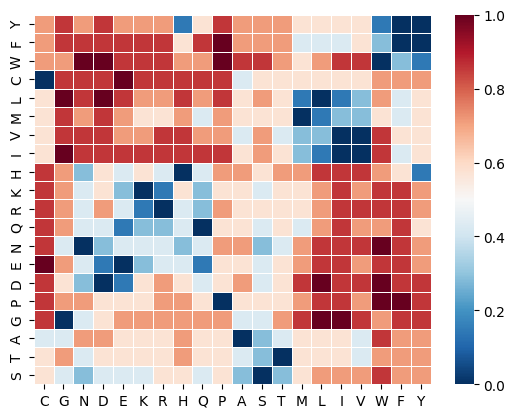

In [98]:
sns.heatmap(blosum_ordered, cmap='RdBu_r', vmin=0, vmax=1, fmt=".2f", linewidths=0.5)

/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_50666/2581856910.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


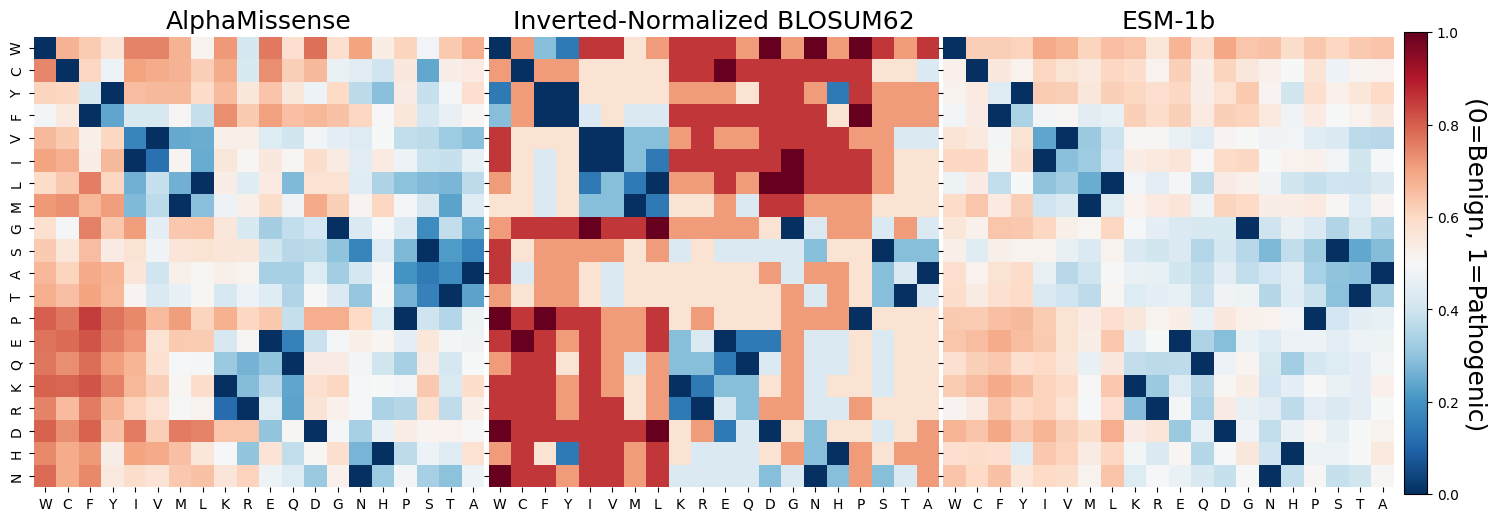

In [162]:
dataset2 = matrix_esm.copy()


# Set common vmin and vmax for consistency
vmin, vmax = 0, 1

# Create a single figure with shared colorbar
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)

# Create a heatmap without colorbar, and capture the mappable for the last one
sns.heatmap(dataset.loc[ordered_row, ordered_column],
            ax=axes[0], cmap='RdBu_r', vmin=vmin, vmax=vmax,
            square=True, cbar=False)
axes[0].set_title("AlphaMissense", fontsize=18)

sns.heatmap(blosum_final.loc[ordered_row, ordered_column],
            ax=axes[1], cmap='RdBu_r', vmin=vmin, vmax=vmax,
            square=True, cbar=False)
axes[1].set_title("Inverted-Normalized BLOSUM62", fontsize=18)

# Capture the mappable from the last heatmap (for colorbar)
hm = sns.heatmap(dataset2.loc[ordered_row, ordered_column],
                 ax=axes[2], cmap='RdBu_r', vmin=vmin, vmax=vmax,
                 square=True, cbar=False)
axes[2].set_title("ESM-1b", fontsize=18)

# Add a single shared colorbar to the right of all subplots
# Use the mappable returned from the last heatmap
cbar = fig.colorbar(hm.get_children()[0], ax=axes, orientation='vertical', fraction=0.025, pad=-0.175)
cbar.set_label("(0=Benign, 1=Pathogenic)", rotation=270, labelpad=20, fontsize=18)

# Final layout
plt.tight_layout()
plt.savefig(get_paths()["images_path"] / "1.4.Substitution_matrix" / "dendrogrammed_BLOSUM62_human_am_esm.png", bbox_inches='tight', dpi=300)
plt.show()
